In [334]:
import sqlite3 as sql
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from itertools import combinations

from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report

import plotly.graph_objs as go
import plotly.plotly as py
from plotly.graph_objs import *

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline


In [81]:
df = pd.read_csv('./database.sqlite')

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


- CASEID - case number
- DOF1 - direction of force (highest)
- GAD1 - deformation location (highest)
- PSU - primary sampling unit number
- YEAR - calender year of crash
- STRATIF - case stratum
- BODYTYPE - vehicle body type
- DVEST - estimated highest delta V
- DVBASIS - basis for total deltav V (highest)
- DVTOTAL - total delta V
- MAKE - vehicle make
- MODELYR - vehicle model year
- AGE - age of occupant
- BAGAVAIL - air bag system availability
- BAGDEPLY - air bag system deployed
- BAGFAIL - air bag system failure
- CASENO - case sequence number
- CHTYPE - type of child safety seat
- DEATH - time of death
- HEIGHT - height of occupent
- HOPSTAY - hospital stay
- INJSEV - injury severity (police rating)
- MANAVAIL -
- MANFAIL - 
- MANUSE - manual belt system use 
- OCCNO - occupant number
- ROLE - occupant's role
- SEATPOS - occupant's seat position
- SEX - occupant's sex
- TREATMENT - treatment - mortality
- WEIGHT - occupant's weight

In [82]:
fatal = df.copy()

In [415]:
fatal['year'].value_counts()

2004    489900
2006    448523
2005    441071
2007    209294
2008    167341
2009    102655
2010     82988
2011     78447
2014     48635
2012     46621
2013      9815
2015      8168
Name: year, dtype: int64

In [83]:
fatal.columns

Index(['Unnamed: 0', 'CASEID', 'DOF1', 'GAD1', 'PSU', 'YEAR', 'STRATIF',
       'BODYTYPE', 'DVEST', 'DVBASIS', 'DVTOTAL', 'MAKE', 'MODELYR', 'AGE',
       'BAGAVAIL', 'BAGDEPLY', 'BAGFAIL', 'CASENO', 'CHTYPE', 'DEATH',
       'HEIGHT', 'HOSPSTAY', 'INJSEV', 'MANAVAIL', 'MANFAIL', 'MANUSE',
       'OCCNO', 'ROLE', 'SEATPOS', 'SEX', 'TREATMNT', 'WEIGHT'],
      dtype='object')

In [84]:
# changing all columns to lower case
columns = fatal.columns
columns_lower = []
for col in columns:
    columns_lower.append(col.lower())
fatal.columns = columns_lower

In [85]:
## removed unnamed: 0 column since it matched the index
fatal.drop(labels='unnamed: 0',axis=1,inplace=True)

In [86]:
# dictionay of categorie ID's (named how they will appear when get dummies is applied)
dvest = {'dvest_0':'reconstructed_dv','dvest_1':'dv<10kmph','dvest_2':'10 >= dv < 25kmph','dvest_3':'25 >= dv < 40kmph',
         'divest_4':'40 >= dv <55kmph','divest_5':'dv >= 55kmph','divest_6':'minor damage','divest_7':'moderat damage',
         'divest_8':'severe damage'}

dvbasis = {'dvbasis_0':'not_ispctd','dvbasis_1':'S_dmg_only','dvbasis_2':'S_dmg_&_trjctry','dvbasis_3':'S_missing_vhcl', 
           'dvbasis_4':'S_dmg_cdc_only', 'dvbasis_5':'one_vhcle_byond_S_scope','dvbasis_6':'rollover',
           'dvbasis_7':'non_hrzntl_forces','dvbasis_8':'sideswipe_dmg','dvbasis_9':'severe_override',
          'dvbasis_10':'ylding_objct','dvbasis_11':'overlapping_dmg','dvbasis_12':'insuf_data',
           'dvbasis_98':'other','dvbasis_99':'unknown'}

gad1 = {'gad1_F':'front','gad1_L':'left','gad_R':'right','gad1_B':'back','gad1_uk':'unkown','gad1_T':'top',
        'gad1_U':'undercarriage'}


bagavail = {'bagavail_1':'no','bagavail_2':'yes','bagavail_3':'unknown'}
# stratif = {'stratif_k':'fatality','stratif_F':'injry_no_tow_hsptl',
#           'stratif_E':'injry_tow','stratif_C':'two_tow_no_hsptl','stratif_D':}
# air bad deployed 
bagdeply = {'bagdeply_0':'no_bag', 'bagdeply_1':'impct_deply','bagdeply_3':'deply_ukdetls',
            'bagdeply_5':'uk_deply','bagdeply_7':'no_deply'}

# air bag failure
bagfail = {'bagfail_0':'no_bag','bagfail_1':'no','bagfail_2':'yes'}

# child seat type
chtype = {'chtype chtype _0':'none','chtype_1':'conv_seat','chtype_2':'frwd_face','chtype_3':'infnt_seat',
          'chtype_4':'boost_seat','chtype_7':'vest','chtype_8':'harness'}

# Injury severity
injsev = {'injsev_0':'no_inj','injsev_1':'pssbl_inj','injsev_2':'n_incptng_inj','injsev_3':'incptng_inj',
          'injsev_4':'killed','injsev_5':'inj_sev_uk','injsev_6':'die_b4_crsh'}

# Drop mannavail since it's same data as manuse
# Manual seatbelt used
manuse = {'manuse_0':'none','manuse_1':'inoperative','manuse_2':'shldr_b','manuse_3':'lap_b',
          'manuse_4':'laphshldr_b','manuse_5':'b_avail_uk','manuse_8':'othr_b_use',
          'manuse_12':'shldr_chld_seat','manuse_13':'lap_chld_seat','manuse_14':'lapshldr_chld_seat',
          'manuse_15':'b_chld_seat_uk','manuse_18':'othrb_chld_seat'}

# Manual seatbelt fail
manfail = {'manfail_0':'nouse','manfail_1':'no_mlfctn',
           'manfail_2':'torn_wbbng','manfail_3':'bckl',
           'manfail_4':'uppr_anchr','manfail_5':'othr_anchr',
           'manavail_6':'retrctr','manavail_7':'combo',
           'manfail_8':'other'}

role = {'role_1':'driver','role_2':'passenger'}



In [87]:
# replace 9 with uk for (unknown per the NASS documents)
# fatal['gad1'] = fatal['gad1'].copy().replace('9','uk')

In [88]:
# replace 0 with 1 since they are the same thing according to the NASS documents
fatal['bagavail'] = fatal['bagavail'].copy().replace(0,1,axis=0)

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warnings.warn('the "axis" argument is deprecated '


In [89]:
# according NASS psu and caseno are same info as caseid and all are not relevant to the scope
fatal.drop(['psu', 'caseno', 'caseid'],axis=1,inplace=True)

In [90]:
# remove manavail since manuse gives the same information
fatal.drop('manavail', axis=1, inplace=True)

In [91]:
# remove bagavail since bagdeply has the same information
fatal.drop('bagavail', axis=1, inplace=True)

In [92]:
#  Remove occno since it's same informaton covered by seatpos
fatal.drop('occno', axis=1, inplace=True)

In [93]:
#  Remove these columns becuase they all conatain the same information as the target
fatal.drop(['death','hospstay','stratif','treatmnt'], axis=1, inplace=True)

In [94]:
# Change 1 to 0
fatal['role'].replace(to_replace=[1,2], value=[0,1], inplace=True, axis=0)

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warnings.warn('the "axis" argument is deprecated '


In [95]:
# removing 2 from bagfail (only 0.2% of the data and stands for "not available")
fatal = fatal[ fatal['bagfail'].isin([0,1]) ]

In [96]:
# Dictionary of each column's unique values key = counts, value = feature name
unique_dict = {}
for col in fatal.columns:
    unique_dict[col] =  fatal[col].nunique()

# Features <30 counts
categoricals = []
for key in unique_dict.keys():
    if unique_dict[key] < 30:
        categoricals.append(key)

In [97]:
for col in categoricals:
    print(col)
    print(fatal[col].value_counts())

gad1
F    1128361
L     333641
R     263584
B     255902
9      67171
T      53171
U       2530
Name: gad1, dtype: int64
year
2004    489900
2006    448523
2005    441071
2007    209294
2008    167341
2009    102655
2010     82988
2011     78447
2014     48635
2012     46621
2013      9815
2015      8168
Name: year, dtype: int64
dvest
0.0    1419768
7.0     242927
6.0      99967
8.0      66570
2.0       9683
3.0       4216
1.0       2181
5.0       2180
4.0        913
Name: dvest, dtype: int64
dvbasis
1.0     919565
3.0     455036
11.0    214754
0.0     152731
4.0      91733
7.0      53181
5.0      43827
10.0     40983
98.0     33203
6.0      30348
9.0      26842
8.0      14917
2.0       1018
Name: dvbasis, dtype: int64
bagdeply
1.0    750620
7.0    704252
0.0    670908
3.0      7678
Name: bagdeply, dtype: int64
bagfail
1.0    1498618
0.0     634840
Name: bagfail, dtype: int64
chtype
0.0    2036408
3.0      26446
8.0      22419
4.0      21949
2.0      12367
1.0      10747
7.0       2100

In [98]:
# Grouping:
# (0, 1, 2,) --> non-sevear
# (3) --> sevear
# (4, 6) --> death 
# 5 is injured, but unknown severity --> need to impute
fatal['injsev'].value_counts()

0.0    728289
3.0    480384
1.0    455692
2.0    332879
4.0     69996
5.0     27060
6.0        15
Name: injsev, dtype: int64

In [99]:
# reviewing null values
fatal.isnull().sum()

dof1        160761
gad1         29098
year             0
bodytype      1433
dvest       285053
dvbasis      55320
dvtotal     757839
make          7355
modelyr       9016
age          34142
bagdeply         0
bagfail          0
chtype        1022
height      337362
injsev       39143
manfail     161532
manuse       74961
role            10
seatpos       9116
sex          20482
weight      310898
dtype: int64

In [100]:
# dvtotal has 1,091,276 null values.  From the analysis below, that accounts 35 to 50 % of each year's data
# Dropping these Na data points
dvtotal_na = pd.DataFrame(fatal[ fatal['dvtotal']\
                                .isnull() ]['year']\
                                .value_counts()).sort_index(ascending=True)

total = pd.DataFrame(fatal['year'].value_counts()).sort_index(ascending=True)

na_percent = pd.concat([dvtotal_na,total], axis=1)
na_percent.columns = ['NAs','Total']

na_percent['Percentage'] = (na_percent['NAs'] / na_percent['Total']).round(3)

print(na_percent.sort_index(ascending=True))
print()
print('There is an average of {}'.format(na_percent['Percentage'].mean()*100) + '% NA values')

         NAs   Total  Percentage
2004  157079  489900       0.321
2005  150822  441071       0.342
2006  162134  448523       0.361
2007   78587  209294       0.375
2008   65398  167341       0.391
2009   39786  102655       0.388
2010   33540   82988       0.404
2011   31318   78447       0.399
2012   17803   46621       0.382
2013    3031    9815       0.309
2014   15902   48635       0.327
2015    2439    8168       0.299

There is an average of 35.81666666666667% NA values


## Try Dropping NA

In [101]:
fatal_nona = fatal.copy()

# dropping all Na values ~ 42% of the data
fatal_nona.dropna(axis=0,inplace=True, )

# resetting the index
fatal_nona.reset_index(drop=True, inplace=True)

In [102]:
# Identifying the colunsm that have float values
floats = fatal_nona.dtypes[ fatal_nona.dtypes == 'float64' ].index.tolist()

# Converting those floats to integers
fatal_nona[floats] = fatal_nona[floats].astype('int')

In [103]:
# apply get dummies on the string values in gad1 column
fatal_nona = pd.concat([fatal_nona, pd.get_dummies(fatal_nona[['gad1']])], axis=1) 

In [268]:
!ls

2014 NASS CDS Coding & Editing Manual.pdf
2015 Analytical User’s Manual.pdf
README.md
data_contents.txt
database.csv
database.sqlite
fatalit_facts.ipynb
fatality_facts_nona
fatalityfacts.zip
planB


In [269]:
fatal_nona.to_csv('fatality_facts_nona.csv')

### Imputing 'injsev' category 5 (Injury-Unknown Severity)

In [104]:
impute_five = fatal_nona.copy()

In [105]:
impute_five.columns

Index(['dof1', 'gad1', 'year', 'bodytype', 'dvest', 'dvbasis', 'dvtotal',
       'make', 'modelyr', 'age', 'bagdeply', 'bagfail', 'chtype', 'height',
       'injsev', 'manfail', 'manuse', 'role', 'seatpos', 'sex', 'weight',
       'gad1_B', 'gad1_F', 'gad1_L', 'gad1_R', 'gad1_T', 'gad1_U'],
      dtype='object')

In [106]:
impute_five['injsev'].value_counts()

0    370186
3    246962
1    242300
2    169680
4     30412
5     10323
6         8
Name: injsev, dtype: int64

In [107]:
impute_five['injsev'].value_counts()

0    370186
3    246962
1    242300
2    169680
4     30412
5     10323
6         8
Name: injsev, dtype: int64

In [108]:
# baseline accuracy of predicting 0-4 categories
injsev_0 = impute_five['injsev'].value_counts()[0]/len(impute_five[ impute_five['injsev'] != 5 ])
injsev_1 = impute_five['injsev'].value_counts()[1]/len(impute_five[ impute_five['injsev'] != 5 ])
injsev_2 = impute_five['injsev'].value_counts()[2]/len(impute_five[ impute_five['injsev'] != 5 ])
injsev_3 = impute_five['injsev'].value_counts()[3]/len(impute_five[ impute_five['injsev'] != 5 ])
injsev_4 = impute_five['injsev'].value_counts()[4]/len(impute_five[ impute_five['injsev'] != 5 ])

print('0 baseline = {:.3} \n1 baseline = {:.3} \n2 baseline = {:.3} \n3 baseline = {:.3} \n4 baseline = {:.3}'\
      .format(injsev_0, injsev_1, injsev_2, injsev_3, injsev_4))

0 baseline = 0.349 
1 baseline = 0.229 
2 baseline = 0.16 
3 baseline = 0.233 
4 baseline = 0.0287


In [109]:
X_train = impute_five[ impute_five['injsev'] != 5 ].drop(['injsev','gad1'], axis=1)
y_train = impute_five[ impute_five['injsev'] != 5 ]['injsev']

X_test = impute_five[ impute_five['injsev'] == 5 ].drop(['injsev','gad1'], axis=1)
y_test = impute_five[ impute_five['injsev'] == 5 ]['injsev']

In [110]:
# Standardizing the train and test data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

In [111]:
# Capturing the indices of y_test to reset the prediction's into indice locations for 'injsev'
y_test_index = y_test.index.tolist()

In [112]:
# Decisiion tree multiclassification to impute the cat. 5 (unknown severity) feature
dt_impute = DecisionTreeClassifier()
dt_impute.fit(X_train_ss, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [113]:
s = cross_val_score(dt_impute, X_train_ss, y_train, cv=5 , n_jobs=2)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.278 ± 0.016


In [114]:
# although the accuracy is not very good for the estimations, 
#(0, 1, 2) were going to be classified as 'unsevere'
# (3) will be 'severe' and there were only 8% of fives classified as 3

print(set(dt_impute.predict(X_test_ss).tolist()))
print('0 sum = ',(dt_impute.predict(X_test_ss)==0).sum())
print('1 sum = ',(dt_impute.predict(X_test_ss)==1).sum())
print('2 sum = ',(dt_impute.predict(X_test_ss)==2).sum())
print('3 sum = ',(dt_impute.predict(X_test_ss)==3).sum())
print('4 sum = ',(dt_impute.predict(X_test_ss)==4).sum())
print()
print('Percent of 4 = ',(dt_impute.predict(X_test_ss)==4).sum()/dt_impute.predict(X_test_ss).sum())

{0, 1, 2, 3, 4}
0 sum =  3538
1 sum =  2583
2 sum =  1507
3 sum =  2203
4 sum =  492

Percent of 4 =  0.03471144348807676


In [115]:
cat_five_imputed = pd.Series(dt_impute.predict(X_test_ss).tolist(), index=y_test_index)
# fatal_nona.replace(to_replace = fatal_nona[ fatal_nona['injsev']==5 ]['injsev'],
#                    value = cat_five_imputed,
#                    axis=0,
#                   inplace=True)


In [116]:
cat_five_imputed

2744       3
2750       1
2756       3
2762       1
2768       3
2774       1
2780       3
2786       1
2792       3
2798       1
2804       3
2810       1
2816       3
2822       1
2828       3
2834       1
2840       3
2846       1
2852       3
2858       1
2864       3
2870       1
2876       3
2882       1
2888       3
2894       1
2900       3
2906       1
2912       3
2918       1
          ..
1066819    3
1066822    3
1066825    3
1066828    3
1066831    3
1066834    3
1066837    3
1066840    3
1066843    3
1066846    3
1066849    3
1066852    3
1066890    1
1066891    1
1066893    0
1066894    1
1066896    1
1066897    1
1066899    2
1066900    1
1066901    1
1066902    2
1067774    0
1067775    3
1067776    0
1067777    3
1068280    2
1068284    0
1068288    2
1068292    0
Length: 10323, dtype: int64

In [117]:
print(len(fatal_nona[ fatal_nona['injsev']==5]['injsev']))
print(len(cat_five_imputed))

10323
10323


In [118]:
# Join imputed values with the orginal values in a DataFrame
five_imputed = pd.concat([y_test, cat_five_imputed], axis=1, join='outer').drop('injsev', axis=1)

In [119]:
# Creating a new dataframe from the series created above inorder to rename the column to 'injsev' in order for the
# .update() method can work as expected
five_imputed = pd.DataFrame(five_imputed.values, columns=['injsev'], index=five_imputed.index)

In [120]:
five_imputed.head()

,injsev
2744,3
2750,1
2756,3
2762,1
2768,3


In [121]:
# Updating DataFram with the new imputed value for category 5
# Note:  five_imputed column name matched the column name of the main DataFrame
fatal_nona.update(five_imputed)

In [122]:
# Update changed value type to float; changing back to integer
fatal_nona['injsev'] = fatal_nona['injsev'].astype('int')

## Modeling

In [123]:
# Reducing the categorical "injsev" grouping to 3 categories
# (0, 1, 2) --> 0 (unsevere)
# (3) --> 1 (severe)
# (4,6) --> 2 (death)

fatal_nona.loc[fatal_nona['injsev'].isin([0, 1, 2]), 'injsev'] = int(0)

In [124]:
fatal_nona.loc[fatal_nona['injsev'].isin([3]), 'injsev'] = int(1)

In [125]:
fatal_nona.loc[fatal_nona['injsev'].isin([4, 6]), 'injsev'] = int(2)

In [126]:
fatal_nona.columns

Index(['dof1', 'gad1', 'year', 'bodytype', 'dvest', 'dvbasis', 'dvtotal',
       'make', 'modelyr', 'age', 'bagdeply', 'bagfail', 'chtype', 'height',
       'injsev', 'manfail', 'manuse', 'role', 'seatpos', 'sex', 'weight',
       'gad1_B', 'gad1_F', 'gad1_L', 'gad1_R', 'gad1_T', 'gad1_U'],
      dtype='object')

In [127]:
y = fatal_nona['injsev']
X = fatal_nona.copy().drop(['injsev','gad1'], axis=1)

In [128]:
# creating the test train split for multiclass modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    stratify=fatal_nona['injsev'])

In [129]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(855896, 25) (855896,) (213975, 25) (213975,)


In [130]:
# Standardizing the train and test data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

In [131]:
dt = DecisionTreeClassifier(min_samples_leaf=10)
s = cross_val_score(dt, X_train_ss, y_train, cv=5, n_jobs=2)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.965 ± 0.001


In [132]:
dt.fit(X_train_ss, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [133]:
feature_import = pd.concat([pd.Series(X_train.columns),
                            pd.Series(dt.feature_importances_.tolist())],
                           axis=1).sort_values(1,ascending=False)
feature_import.reset_index(level=0, drop=True, inplace=True)
feature_import.columns = ['feature','importance']

In [134]:
feature_import.set_index('feature', inplace=True)

Text(0.5,0,'Features')

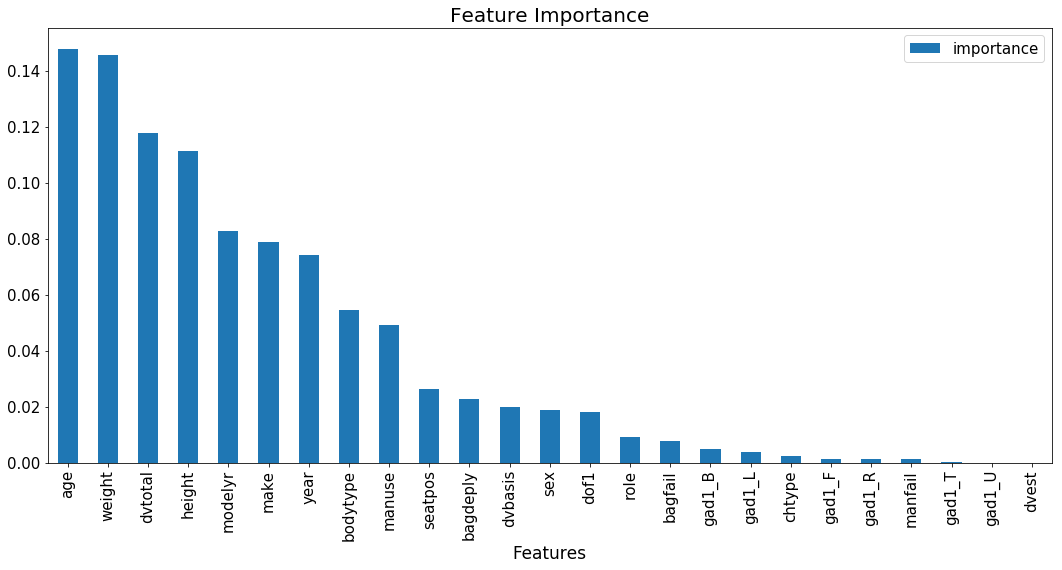

In [135]:
# Plotting the feature importances
plt.figure(figsize=(20,13))
feature_import.plot(kind='bar', 
                    fontsize=15, figsize=(18,8))
plt.legend(fontsize=15)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=17)

In [136]:
print(confusion_matrix(y_test, dt.predict(X_test_ss)))

[[155648   2088    223]
 [  2604  47036    193]
 [   263    183   5737]]


In [137]:
# Setting up y_true and y_pred variable to compose the confusion matrix
y_true = y_test.copy()
y_pred = dt.predict(X_test_ss)

confusion = pd.crosstab(y_true, y_pred)
confusion.columns = ['Unsevere','Severe','Fatal']
confusion

,Unsevere,Severe,Fatal
injsev,,,
0,155648,2088,223
1,2604,47036,193
2,263,183,5737


In [138]:
# Recall (Sensitivity) = TP / (TP + sum(FN))
print('Fatal Recall is: \t{}'.format(5702/(5702 + 197 + 288)))

Fatal Recall is: 	0.9216098270567319


In [139]:
# Precision (Sensitivity) = TP / (TP + sum(FP))
print('Fatal Precision is: \t{}'.format(5702/(5702 + 159 + 237)))

Fatal Precision is: 	0.9350606756313545


In [140]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98    157959
          1       0.95      0.94      0.95     49833
          2       0.93      0.93      0.93      6183

avg / total       0.97      0.97      0.97    213975



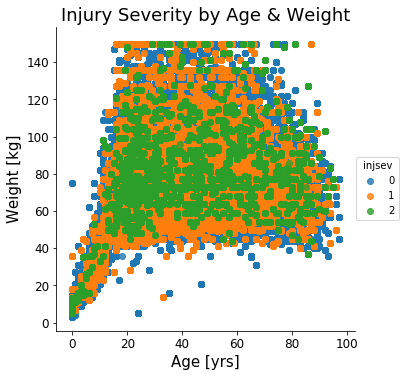

In [141]:
sns.lmplot('age', 'weight',fatal_nona, hue='injsev', fit_reg=False )
plt.xlabel('Age [yrs]', fontsize=15)
plt.ylabel('Weight [kg]', fontsize=15)
plt.title('Injury Severity by Age & Weight', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

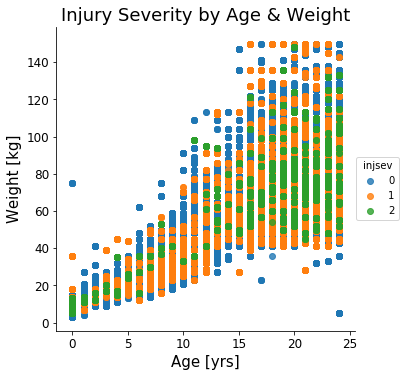

In [142]:
sns.lmplot('age', 'weight',fatal_nona[fatal_nona['age']<=24], hue='injsev', fit_reg=False )
plt.xlabel('Age [yrs]', fontsize=15)
plt.ylabel('Weight [kg]', fontsize=15)
plt.title('Injury Severity by Age & Weight', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


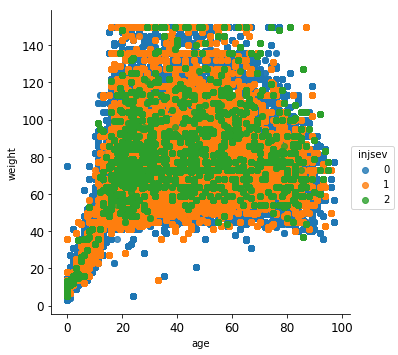

In [143]:
sns.lmplot('age','weight' ,fatal_nona, hue='injsev', fit_reg=False )
# plt.ylabel('Delta Velocity [kmph]', fontsize=15)
# plt.xlabel('Weight [kg]', fontsize=15)
# plt.title('Injury Severity by Weight & Height', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Modeling II Decision Tree with Variable Encoding
- Need to OneHotEncode or pd.get_dummies on the categorical columns

In [166]:
encode_columns = ['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex']

continuous_columns = ['dof1','dvest','dvtotal','age','height','weight',
                     'gad1_B', 'gad1_F','gad1_L', 'gad1_R', 'gad1_T', 'gad1_U']

In [155]:
# Converting the features to encode with pd.get_dummies into a string
X_dummie_coumns = fatal_nona[encode_columns].astype('str')

In [159]:
# Joining the the get dummies columns witht the DataFrame before createing Test/Train split
fatal_nona_two = pd.concat([fatal_nona,pd.get_dummies(X_dummie_coumns)], axis=1)

In [185]:
# X features dropping the target and all features that get dummies were performed on
y = fatal_nona_two['injsev']
X = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)

In [186]:
# creating the test train split for multiclass modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    stratify=fatal_nona['injsev'])

In [189]:
dt = DecisionTreeClassifier(min_samples_leaf=10)
s = cross_val_score(dt, X_train, y_train, cv=5, n_jobs=2)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.963 ± 0.001


In [190]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [191]:
feature_import = pd.concat([pd.Series(X_train.columns),
                            pd.Series(dt.feature_importances_.tolist())],
                           axis=1).sort_values(1,ascending=False)
feature_import.reset_index(level=0, drop=True, inplace=True)
feature_import.columns = ['feature','importance']

In [192]:
feature_import.set_index('feature', inplace=True)

Text(0.5,0,'Features')

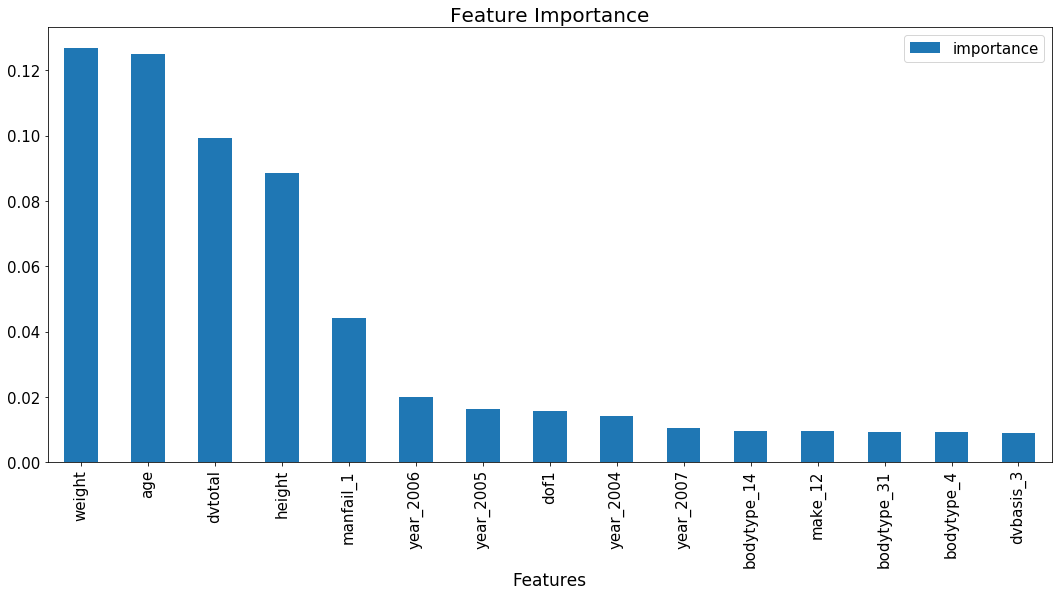

In [200]:
# Plotting the feature importances
plt.figure(figsize=(20,13))
feature_import.iloc[:15].plot(kind='bar', 
                    fontsize=15, figsize=(18,8))
plt.legend(fontsize=15)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=17)

In [201]:
# Setting up y_true and y_pred variable to compose the confusion matrix
y_true = y_test.copy()
y_pred = dt.predict(X_test)

confusion = pd.crosstab(y_true, y_pred)
confusion.columns = ['Unsevere','Severe','Fatal']
confusion

,Unsevere,Severe,Fatal
injsev,,,
0,155487,2235,237
1,2978,46694,161
2,261,192,5730


In [202]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98    157959
          1       0.95      0.94      0.94     49833
          2       0.94      0.93      0.93      6183

avg / total       0.97      0.97      0.97    213975



## Modeling III Decision Tree with Variable Encoding and OneVsRest ROC AUC

In [342]:
# X features dropping the target and all features that get dummies were performed on
y = fatal_nona_two['injsev']
X = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)

In [233]:
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2]) # 3 class output
n_classes = y.shape[1] # shape = (1069871, 3)

# creating the test train split for multiclass modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    stratify=fatal_nona['injsev'])

classifier = OneVsRestClassifier(dt.fit(X_train, y_train))
y_score = classifier.fit(X_train, y_train).predict(X_test)

In [243]:
# Compute ROC curve and ROC area for each class
fpr = {}  # false-positive rate
tpr = {}  # true-positive rate
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

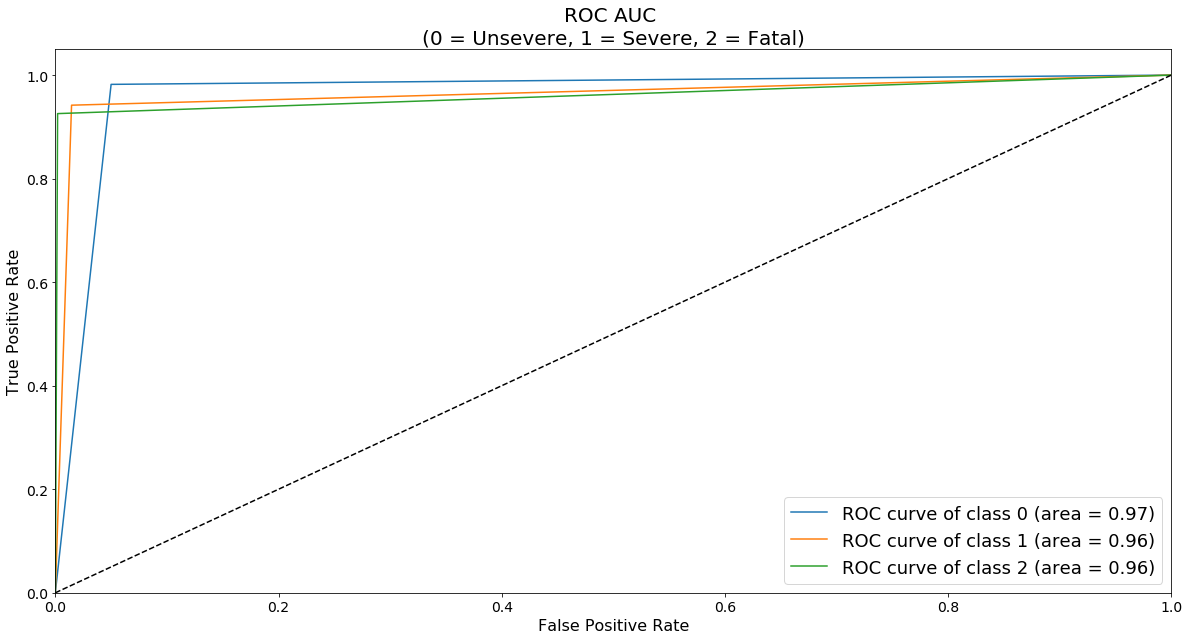

In [265]:
# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
plt.figure(figsize=(20,10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC AUC \n(0 = Unsevere, 1 = Severe, 2 = Fatal)', fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.show()

In [259]:
# Classification Report
y_true = y_test.copy()
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98    157959
          1       0.95      0.94      0.94     49833
          2       0.94      0.92      0.93      6183

avg / total       0.97      0.97      0.97    213975



Text(0.5,0,'Features')

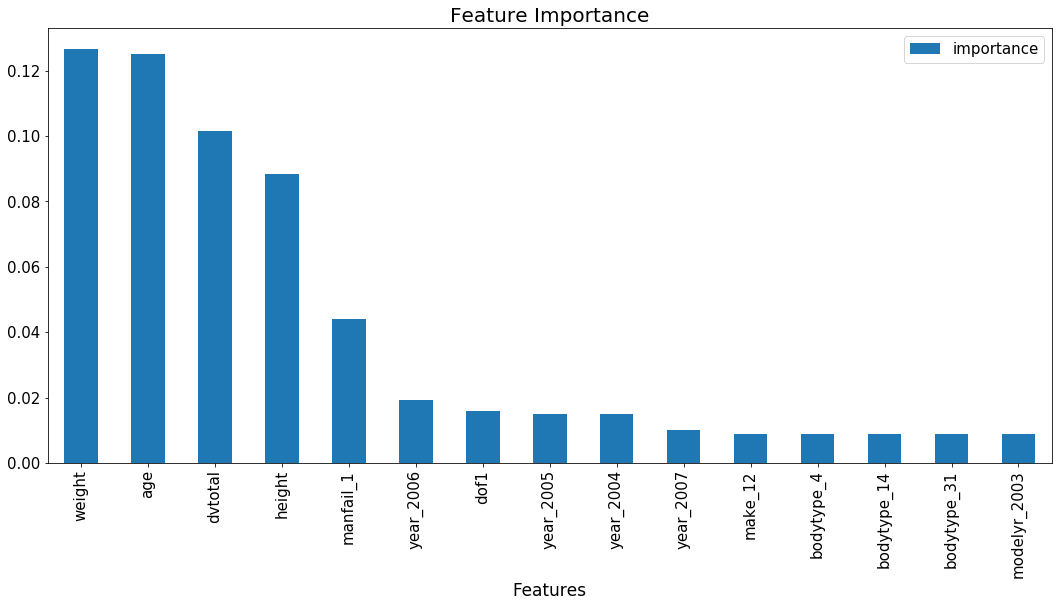

In [264]:
feature_import = pd.concat([pd.Series(X_train.columns),
                            pd.Series(dt.feature_importances_.tolist())],
                           axis=1).sort_values(1,ascending=False)
feature_import.reset_index(level=0, drop=True, inplace=True)
feature_import.columns = ['feature','importance']

feature_import.set_index('feature', inplace=True)

# Plotting the feature importances
plt.figure(figsize=(20,13))
feature_import.iloc[:15].plot(kind='bar', 
                    fontsize=15, figsize=(18,8))
plt.legend(fontsize=15)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=17)

## Model IV: Logistic Regression Multiclassification

### PCA

In [387]:
y = fatal_nona_two['injsev']
X = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)

In [391]:

scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=X.shape[1]))
pipe = Pipeline([scaling, pca])

Xt = pipe.fit_transform(X)

In [406]:
print(fatal_nona_two.shape)
print(Xt.shape)

(1069871, 244)
(1069871, 229)


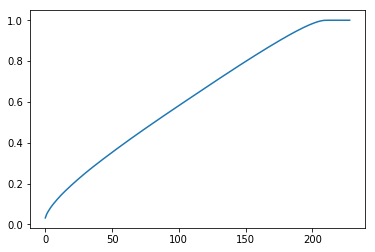

In [392]:
var_exp = pipe.named_steps['pca'].explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
plt.plot(range(len(cum_var_exp)), cum_var_exp)

In [393]:
# Constructed DataFrame of PCA's
features_pca = ['PC'+str(i+1) for i in range(pipe.named_steps['pca'].n_components_)]

features = X.columns

pca_components = pd.DataFrame(pipe.named_steps['pca'].components_.T, columns=features_pca, index=features)

In [394]:
pca_components[['PC1','PC2','PC3','PC4']].sort_values(by='PC1', ascending=False).head(10)

,PC1,PC2,PC3,PC4
bagdeply_0,0.298762,0.092114,0.018335,-0.267877
bagfail_0,0.286629,0.105780,0.021397,-0.293352
role_1,0.271028,-0.075787,-0.374150,0.047367
manuse_14,0.216643,-0.169290,0.264800,0.126211
seatpos_21,0.166048,-0.044006,0.027237,-0.031713
seatpos_23,0.165439,-0.027348,-0.013262,-0.037938
chtype_3,0.136696,-0.095290,0.169101,0.081164
chtype_4,0.127257,-0.096938,0.148495,0.073499
seatpos_22,0.122136,-0.024477,0.068885,0.006515
manuse_13,0.094839,-0.067376,0.124903,0.043945


In [395]:
pca_components[['PC1','PC2','PC3','PC4']].sort_values(by='PC2', ascending=False).head(10)

,PC1,PC2,PC3,PC4
manfail_0,0.090870,0.438432,0.004151,0.227316
manuse_0,0.090807,0.438203,0.003964,0.227498
height,-0.259070,0.182440,-0.152712,-0.177243
chtype_0,-0.246423,0.177302,-0.298909,-0.149428
weight,-0.218767,0.167949,-0.065028,-0.144148
sex_1,-0.012321,0.131795,0.108412,-0.277795
bagfail_0,0.286629,0.105780,0.021397,-0.293352
dvtotal,0.012309,0.097427,0.029301,0.024093
bagdeply_0,0.298762,0.092114,0.018335,-0.267877
role_0,-0.271028,0.075787,0.374150,-0.047367


In [396]:
pca_components[['PC1','PC2','PC3','PC4']].sort_values(by='PC3', ascending=False).head(10)

,PC1,PC2,PC3,PC4
seatpos_11,-0.270999,0.075774,0.374197,-0.047323
role_0,-0.271028,0.075787,0.374150,-0.047367
manuse_14,0.216643,-0.169290,0.264800,0.126211
chtype_3,0.136696,-0.095290,0.169101,0.081164
chtype_4,0.127257,-0.096938,0.148495,0.073499
manuse_13,0.094839,-0.067376,0.124903,0.043945
chtype_1,0.092117,-0.059340,0.113376,0.070524
sex_1,-0.012321,0.131795,0.108412,-0.277795
chtype_2,0.088400,-0.064794,0.105961,0.043257
chtype_8,0.082930,-0.061233,0.105556,0.037736


/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning:

The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.



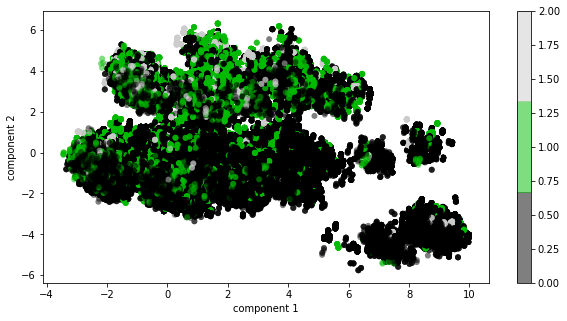

In [412]:
plt.figure(figsize=(10,5))
plt.scatter(Xt[:, 0], Xt[:, 1],
            c=fatal_nona_two['injsev'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 3))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning:

The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.



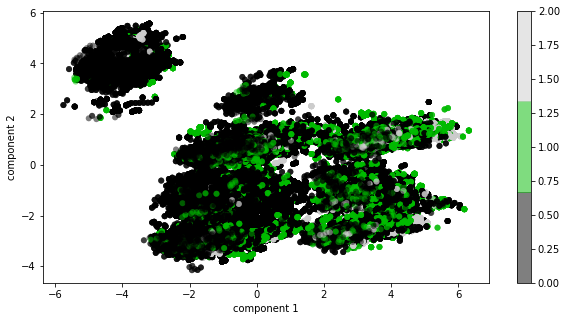

In [413]:
plt.figure(figsize=(10,5))
plt.scatter(Xt[:, 1], Xt[:, 2],
            c=fatal_nona_two['injsev'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 3))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [ ]:
features = X.columns
X_pca = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)
y_pca = fatal_nona_two['injsev']

for features_2 in combinations(features, 10):
    X_pca = fatal_nona_two[list(features_2)]
    ss = StandardScaler()
    Xs = ss.fit_transform(X_pca)
    logreg = LogisticRegression(multi_class='multinomial', solver='sag')
    print(features_2, cross_val_score(logreg, Xs, y_pca, cv=5).mean())

In [296]:
# X features dropping the target and all features that get dummies were performed on
y = fatal_nona_two['injsev']
X = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)

In [299]:
# creating the test train split for multiclass modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    stratify=fatal_nona['injsev'])

In [306]:
# mul_lr = LogisticRegression(multi_class='multinomial', solver='newton-cg')
# mul_lr.fit(X_train, y_train)

In [ ]:

def build_tree_models(x, y, tree_depth_range=range(1,11), min_leaf):
    tree_model_ypreds = {}
    
    for i in tree_depth_range:
        model = DecisionTreeRegressor(max_depth=i, min_samples_leaf=min_leaf)
        model.fit(x[:, np.newaxis], y)
        tree_model_ypreds[i] = model.predict(x[:, np.newaxis])
        
    return tree_model_ypreds

In [ ]:
def mph(kmph):
    '''
    Function to convert kmph to mph.  
    Enter the speed in kmph and the function converts it to mph.
    - default set to 0.0001
    '''
    return round(0.621371*kmph)

In [ ]:
plt.figure(figsize=(20,13))
mask = np.zeros_like(X_train.corr()[X_train.corr()>0.20])
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(X_train.corr()[X_train.corr()>0.20], mask=mask, vmax=.3, annot=True, square=True)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Features Correlations', fontsize = 25)
plt.show()
